# Preprocessing pipeline

Objective of this notebook is to aggregate aggregate seismic processing actions into a neat pipeline. 

* [Dataset](#Dataset)
* [Pipeline](#Pipeline)
* [Conclusion](#Conclusion)
* [Suggestions for improvement](#Suggestions-for-improvement)

In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from time import time

In [2]:
from seismicpro import FieldIndex, TraceIndex, SeismicBatch, SeismicDataset
from seismicpro.batchflow import Dataset, Pipeline, V, B, D, L, I

from seismicpro.src import (seismic_plot,
                            gain_plot, calculate_sdc_quality,
                            measure_gain_amplitude, merge_segy_files
                           )

## Dataset

For this task we make use of Dataset 1 for processing testing. It contains several records with various amplitude range:

In [3]:
path_raw = '/data/preproc/1_input_4_PREP_full_pipeln.sgy'
field_index = FieldIndex(name='raw', path=path_raw, extra_headers='all')
field_set = SeismicDataset(field_index, SeismicBatch)

field_index.head()

,CoordinateUnits,NStackedTraces,UnassignedInt2,SourceGroupScalar,CDP_Y,TotalStaticApplied,SourceMeasurementUnit,GroupWaterDepth,DayOfYear,GroupUpholeTime,...,ElevationScalar,ReceiverDatumElevation,HighCutFrequency,SweepTraceTaperLengthStart,HighCutSlope,TaperType,CDP,CROSSLINE_3D,TRACE_SEQUENCE_FILE,file_id
,,,,,,,,,,,...,,,,,,,,,raw,raw
FieldRecord,,,,,,,,,,,,,,,,,,,,,
8834,1,0,584122368,-3,19835984,0,0,0,67,0,...,-7,0,0,0,0,0,667565,587,1,/data/preproc/1_input_4_PREP_full_pipeln.sgy
8834,1,0,584187904,-3,19835984,0,0,0,67,0,...,-7,0,0,0,0,0,667566,588,2,/data/preproc/1_input_4_PREP_full_pipeln.sgy
8834,1,0,584253440,-3,19835984,0,0,0,67,0,...,-7,0,0,0,0,0,667567,589,3,/data/preproc/1_input_4_PREP_full_pipeln.sgy
8834,1,0,584318976,-3,19835984,0,0,0,67,0,...,-7,0,0,0,0,0,667568,590,4,/data/preproc/1_input_4_PREP_full_pipeln.sgy
8834,1,0,584384512,-3,19835984,0,0,0,67,0,...,-7,0,0,0,0,0,667569,591,5,/data/preproc/1_input_4_PREP_full_pipeln.sgy


Let's take a look a the raw data before processing it:

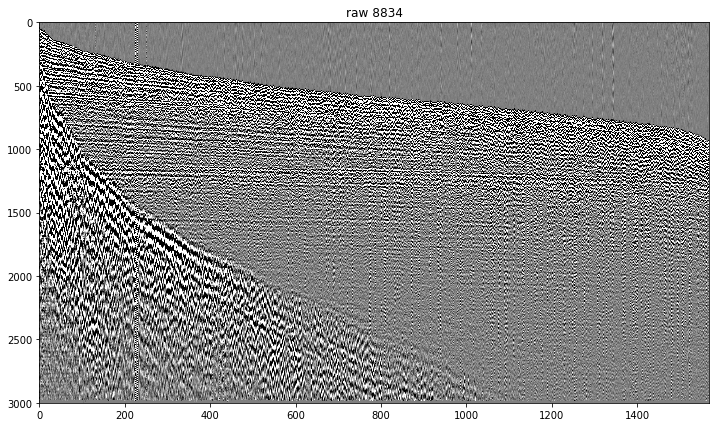

In [4]:
(SeismicDataset(field_index).next_batch(1)
         .load(components='raw', fmt='segy')
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .seismic_plot('raw', field_index.indices[0], figsize=(12, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Pipeline

For spherical divergence correction we'll use predefined speed values:

In [5]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)

In this pipeline we preform spherical divergence correction (SDC), remove traces that contain more than 50 consequent zero values, and estimate parameters for quatile normalization. 

Parameters for SDC are calculated via optimization procedure only once for all dataset in `before` instance of pipeline and saved to `SeismicDataset`'s attribute. Parameters for normalization are updated after each batch and also saved to `SeismicDataset`'s attribute to be used in following pipeline.

In [6]:
first_preproc_ppl = (
    field_set.pipeline()
    .init_variable('sdc_params')
    .load(fmt='sgy', components='raw')
    .correct_spherical_divergence(src='raw', dst='raw', speed=speed, params=D('sdc_params'))
    .drop_zero_traces(src='raw', dst='raw', num_zero=50)
    .find_equalization_params(B(), component='raw', record_id_col='YearDataRecorded')
    .run_later(batch_size=5, n_epochs=1, shuffle=False, drop_last=False, bar=True)
    )

(first_preproc_ppl.before
                  .find_sdc_params(component='raw', speed=speed, loss=calculate_sdc_quality, initial_point=(2, 1), save_to=D('sdc_params')))

Let's run it:

In [7]:
first_preproc_ppl.run()

100%|██████████| 6/6 [02:47<00:00, 28.15s/it]


Second pipeline used parameters from the dataset to process and then save each batch. In `after` instance of pipeline we merge all saved batches in resulting SEG-Y file:

In [8]:
tmp_dump_path = '/data/preproc/tmp/'
output_path = '/data/preproc/processed/merged.sgy'

second_preproc_ppl = (
    field_set.pipeline()
    .load(fmt='sgy', components='raw')
    .correct_spherical_divergence(src='raw', dst='raw', speed=speed, params=D('sdc_params'))
    .drop_zero_traces(src='raw', dst='raw', num_zero=50)
    .equalize(src='raw', dst='raw', params=D('equal_params'))
    .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()),
          src='raw', fmt='segy', split=False)
    .run_later(batch_size=5, n_epochs=1, shuffle=False, drop_last=False, bar=True)
)

(second_preproc_ppl.after
                  .merge_segy_files(output_path=output_path, extra_headers='all', path=os.path.join(tmp_dump_path, '*.sgy')))

Run second pipeline:

In [9]:
second_preproc_ppl.run()

100%|██████████| 6/6 [00:21<00:00,  3.80s/it]


Now we can take a look at the result:

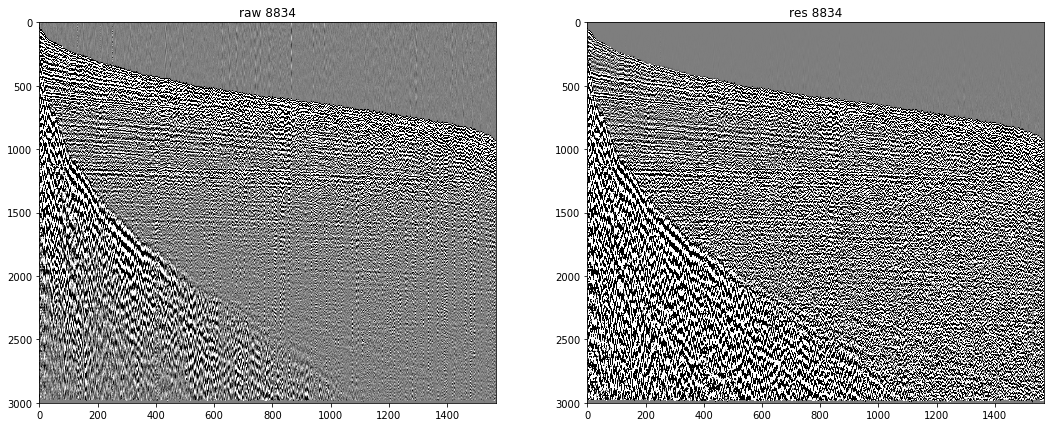

In [10]:
result_index = FieldIndex(name='res', path=output_path).merge(FieldIndex(name='raw', path=path_raw, extra_headers='all'))

(SeismicDataset(result_index).next_batch(1)
         .load(components=('raw', 'res'), fmt='segy')
         .sort_traces(src=('raw', 'res'), dst=('raw', 'res'), sort_by='offset')
         .seismic_plot(('raw', 'res'), field_index.indices[0], figsize=(18, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Conclusion

Current version of notebook contains preprocessing pipeline with three actions: correction for spherical divergence, removal of traces with more than 50 consecuent zeros and equalization of amplitudes.

#### Time estimates
* Calculation of SDC and normalization parameters: ~ 150 seconds for 30 fields with batch size equal to 5;
* Preprocessing actions and dump: ~ 45 seconds for 30 fields batch size equal to 5;
* Merging SEG-Y: ~ 20 seconds for 6 files.

## Suggestions for improvement

The next step in development of pipeline is adding two more actions: correction of inverted traces and attenuation of industrial noise.